           Brand    Price       Body  Mileage  EngineV Engine Type  \
0            BMW   4200.0      sedan      277      2.0      Petrol   
1  Mercedes-Benz   7900.0        van      427      2.9      Diesel   
2  Mercedes-Benz  13300.0      sedan      358      5.0         Gas   
3           Audi  23000.0  crossover      240      4.2      Petrol   
4         Toyota  18300.0  crossover      120      2.0      Petrol   

  Registration  Year         Model  
0          yes  1991           320  
1          yes  1999  Sprinter 212  
2          yes  2003         S 500  
3          yes  2007            Q7  
4          yes  2011         Rav 4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   i

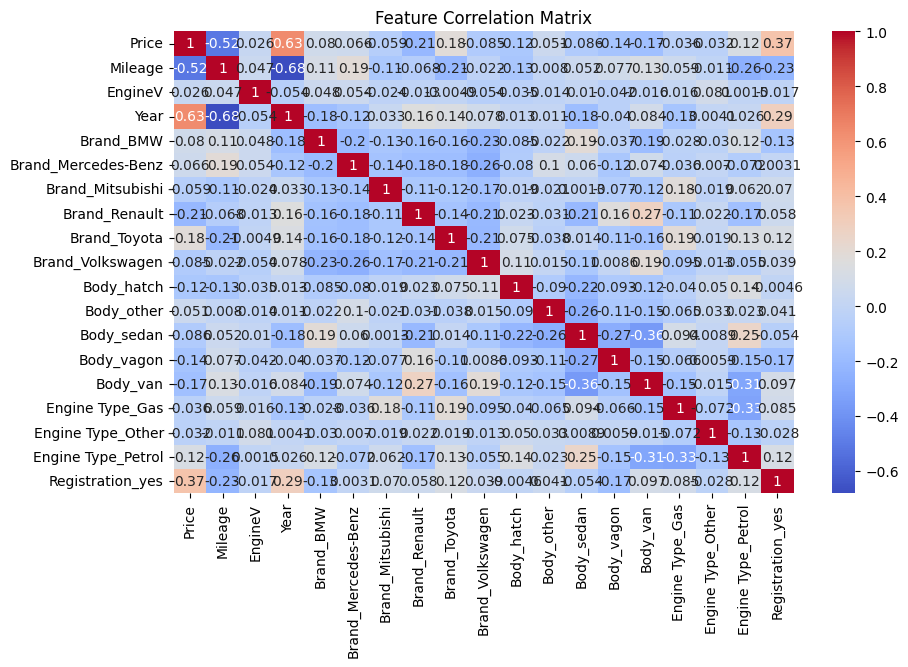

Original features: 4
Reduced features (PCA): 4


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load dataset
df = pd.read_csv("car_sales.csv")

# Show first few rows
print(df.head())

# Basic info
print(df.info())
print(df.describe())

# step 1 : Data Cleaning

print("Data Cleaing");

df.isnull().sum()
df = df.dropna()
# Fill missing 'Price' with median
df['Price'] = df['Price'].fillna(df['Price'].median())

# Fill missing 'Fuel_Type' with mode
df['Engine Type'] = df['Engine Type'].fillna(df['Engine Type'].mode()[0])

# Drop rows if 'Model' is missing
df = df.dropna(subset=['Model'])

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

# Treat noisy data
df = df[(df['Year'] >= 1990) & (df['Year'] <= 2025)]
df = df[df['Price'] > 0]

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Filter outliers
df = df[(df['Price'] >= lower) & (df['Price'] <= upper)]

print(df.info())
print(df.describe())

# step 2 : Data Transformation

print("Data Transformation");
# Label Encode 'Model' (too many unique values)
le = LabelEncoder()
df['Model'] = le.fit_transform(df['Model'])

# One-Hot Encode other categorical columns
df = pd.get_dummies(df, columns=['Brand', 'Body', 'Engine Type', 'Registration'], drop_first=True)

scaler = MinMaxScaler()
df[['Price', 'Mileage', 'EngineV', 'Year']] = scaler.fit_transform(
    df[['Price', 'Mileage', 'EngineV', 'Year']]
)


df['Price'] = np.log1p(df['Price'])
df['Mileage'] = np.log1p(df['Mileage'])

df['Price_Level'] = pd.cut(df['Price'], bins=3, labels=['Low', 'Medium', 'High'])

print(df.head())
print(df.info())

# step 3 : Data Reduction

print("Data Reduction");
# Remove unnecessary columns
df = df.drop(['Model'], axis=1)


# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Display correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Example: if EngineV and Price are highly correlated
if abs(corr_matrix.loc['Price', 'EngineV']) > 0.9:
    df = df.drop(['EngineV'], axis=1)

# Remove columns with 0 variance
df = df.loc[:, df.apply(pd.Series.nunique) != 1]

#step 4 PCA

# Standardize numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% variance
principal_components = pca.fit_transform(scaled_data)

print(f"Original features: {scaled_data.shape[1]}")
print(f"Reduced features (PCA): {principal_components.shape[1]}")

df.to_csv("car_sales_final.csv", index=False)
